# Script Set Up

In [1]:
%matplotlib inline

In [2]:
!pip install mne

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 44.9 MB/s eta 0:00:00


In [3]:
!pip install pingouin
import pingouin as pg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.6/198.6 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7026 sha256=1acbb49b04c2cbed5ef57ceb0c89085e99b99a8e3a9cda1a9254b7e09ed60738
  Stored in directory: /root/.cache/pip/wheels/3d/fe/b0/27a9892da57472e538c7452a721a9cf463cc03cf7379889266
Successfully built littleutils


In [4]:
pip install h5io --upgrade

In [5]:
import os
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
import pandas as pd
import seaborn as sns
import mne
import math
from scipy.io import loadmat
from scipy.fft import fft

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Deciding what response times are outliers that should be removed

In [7]:
lower_RT_cutoff = 150
upper_RT_cutoff = 1500 # 1.5x longest SI and is less than 1% of trials

# Load Data

In [8]:
ID_list = ['P1', 'P3', 'P4', 'P7', 'P10', 'P12', 'P15', 'P17', 'P19',
           'P21', 'P22', 'P23', 'P24', 'P26', 'P27', 'P28', 'P29', 'P30']

n_participants = len(ID_list)
n_channels = 128
n_times_encode = 41
n_times_repo = 33
n_times_RL = 33
n_freqs = 1
fs_beta = [8, 30]

sample_rate = 512

encode_epochs = []
encode_metadata = []
repo_epochs = []
repo_metadata = []
RL_epochs = []
RL_metadata = []

all_encode_beta = np.zeros([len(ID_list), n_channels, n_freqs, n_times_encode])
all_repo_beta = np.zeros([len(ID_list), n_channels, n_freqs, n_times_repo])
all_RL_beta = np.zeros([len(ID_list), n_channels, n_freqs, n_times_RL])


for i in range(0, len(ID_list)):
  ID = ID_list[i]
  encode_fname = "/content/drive/MyDrive/Time_Reproduction/Beta_Epochs/" + ID + "_encode_beta_epochs-tfr.h5"
  repo_fname = "/content/drive/MyDrive/Time_Reproduction/Beta_Epochs/" + ID + "_repo_beta_epochs-tfr.h5"
  RL_fname = "/content/drive/MyDrive/Time_Reproduction/Beta_Epochs/" + ID + "_RL_beta_epochs-tfr.h5"

  encode_epochs_participant = mne.time_frequency.read_tfrs(encode_fname)
  encode_epochs_participant = encode_epochs_participant[0]
  repo_epochs_participant = mne.time_frequency.read_tfrs(repo_fname)
  repo_epochs_participant = repo_epochs_participant[0]
  RL_epochs_participant = mne.time_frequency.read_tfrs(RL_fname)
  RL_epochs_participant = RL_epochs_participant[0]

  info = encode_epochs_participant.info

  beta_time = encode_epochs_participant.times # defining times
  beta_time_repo = repo_epochs_participant.times
  beta_time_RL = RL_epochs_participant.times

  # Adding ID column to metadata 19/12/22
  encode_df = encode_epochs_participant.metadata
  encode_df["ID"] = ID # adding ID column
  temp_cols=encode_df.columns.tolist()
  new_cols=temp_cols[-1:] + temp_cols[:-1]
  encode_df=encode_df[new_cols]
  encode_metadata.append(encode_df)

  repo_df = repo_epochs_participant.metadata
  repo_df["ID"] = ID # adding ID column
  temp_cols=repo_df.columns.tolist()
  new_cols=temp_cols[-1:] + temp_cols[:-1]
  repo_df=repo_df[new_cols]
  repo_metadata.append(repo_df)

  RL_df = RL_epochs_participant.metadata
  RL_df["ID"] = ID # adding ID column
  temp_cols=RL_df.columns.tolist()
  new_cols=temp_cols[-1:] + temp_cols[:-1]
  RL_df=RL_df[new_cols]
  RL_metadata.append(RL_df)

  ## Average Epochs and Save Result
  #encode_indices = encode_epochs_participant.metadata.query("Miss == 0 & Response_Direction == @j").index
  encode_participant_beta = encode_epochs_participant.average() # taking all epochs here
  all_encode_beta[i] = encode_participant_beta.data

  #repo_indices = repo_epochs_participant.metadata.query("Miss == 0 & Response_Direction == @j").index
  repo_participant_beta = repo_epochs_participant.average() # taking all epochs here
  all_repo_beta[i] = repo_participant_beta.data

  #RL_indices = RL_epochs_participant.metadata.query("Miss == 0 & Response_Direction == @j").index
  RL_participant_beta = RL_epochs_participant.average() # taking all epochs here
  all_RL_beta[i] = RL_participant_beta.data

Reading /content/drive/MyDrive/Time_Reproduction/Beta_Epochs/P1_encode_beta_epochs-tfr.h5 ...
Adding metadata with 10 columns
Reading /content/drive/MyDrive/Time_Reproduction/Beta_Epochs/P1_repo_beta_epochs-tfr.h5 ...
Adding metadata with 10 columns
Reading /content/drive/MyDrive/Time_Reproduction/Beta_Epochs/P1_RL_beta_epochs-tfr.h5 ...
Adding metadata with 10 columns
Reading /content/drive/MyDrive/Time_Reproduction/Beta_Epochs/P3_encode_beta_epochs-tfr.h5 ...
Adding metadata with 10 columns
Reading /content/drive/MyDrive/Time_Reproduction/Beta_Epochs/P3_repo_beta_epochs-tfr.h5 ...
Adding metadata with 10 columns
Reading /content/drive/MyDrive/Time_Reproduction/Beta_Epochs/P3_RL_beta_epochs-tfr.h5 ...
Adding metadata with 10 columns
Reading /content/drive/MyDrive/Time_Reproduction/Beta_Epochs/P4_encode_beta_epochs-tfr.h5 ...
Adding metadata with 10 columns
Reading /content/drive/MyDrive/Time_Reproduction/Beta_Epochs/P4_repo_beta_epochs-tfr.h5 ...
Adding metadata with 10 columns
Readin

# Concatenate Metadata
Concatenate metadata so that all participants epochs are in one dataframe

In [9]:
encode_metadata = pd.concat(encode_metadata, ignore_index = True)
repo_metadata = pd.concat(repo_metadata, ignore_index = True)
RL_metadata = pd.concat(RL_metadata, ignore_index = True)
encode_metadata

,ID,trial_number,Response_Time,Over_Under,Mean_RT,Median_RT,Trigger,Gap,Reject_Artif,RT_gap,Reject_All
0,P1,0,851.562500,0.0,1026.308594,1013.867188,56,431.640625,0.0,1283.203125,0.0
1,P1,1,865.234375,0.0,997.128906,981.640625,53,402.343750,0.0,1267.578125,1.0
2,P1,3,861.328125,0.0,1038.046875,1029.492188,58,373.046875,0.0,1234.375000,1.0
3,P1,4,914.062500,0.0,1013.515625,1011.914062,55,437.500000,0.0,1351.562500,0.0
4,P1,5,880.859375,0.0,945.742188,942.578125,51,437.500000,0.0,1318.359375,0.0
...,...,...,...,...,...,...,...,...,...,...,...
13607,P30,894,1197.265625,1.0,1159.707031,1137.890625,59,402.343750,0.0,1599.609375,0.0
13608,P30,895,923.828125,1.0,884.492188,860.546875,51,443.359375,0.0,1367.187500,0.0
13609,P30,896,912.109375,1.0,892.343750,874.218750,52,355.468750,0.0,1267.578125,0.0
13610,P30,897,1107.421875,1.0,1109.980469,1095.898438,58,443.359375,0.0,1550.781250,0.0


In [10]:
repo_metadata

,ID,trial_number,Response_Time,Over_Under,Mean_RT,Median_RT,Trigger,Gap,Reject_Artif,RT_gap,Reject_All
0,P1,0,851.562500,0.0,1026.308594,1013.867188,156,431.640625,0.0,1283.203125,0.0
1,P1,4,914.062500,0.0,1013.515625,1011.914062,155,437.500000,0.0,1351.562500,0.0
2,P1,5,880.859375,0.0,945.742188,942.578125,151,437.500000,0.0,1318.359375,0.0
3,P1,6,742.187500,0.0,980.234375,965.039062,152,390.625000,0.0,1132.812500,0.0
4,P1,10,832.031250,0.0,980.234375,965.039062,152,417.968750,0.0,1250.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...
13152,P30,894,1197.265625,1.0,1159.707031,1137.890625,159,402.343750,0.0,1599.609375,0.0
13153,P30,895,923.828125,1.0,884.492188,860.546875,151,443.359375,0.0,1367.187500,0.0
13154,P30,896,912.109375,1.0,892.343750,874.218750,152,355.468750,0.0,1267.578125,0.0
13155,P30,897,1107.421875,1.0,1109.980469,1095.898438,158,443.359375,0.0,1550.781250,0.0


In [11]:
RL_metadata

,ID,trial_number,Response_Time,Over_Under,Mean_RT,Median_RT,Trigger,Gap,Reject_Artif,RT_gap,Reject_All
0,P1,0,851.562500,0.0,1026.308594,1013.867188,206,431.640625,0.0,1283.203125,0.0
1,P1,4,914.062500,0.0,1013.515625,1011.914062,205,437.500000,0.0,1351.562500,0.0
2,P1,5,880.859375,0.0,945.742188,942.578125,201,437.500000,0.0,1318.359375,0.0
3,P1,6,742.187500,0.0,980.234375,965.039062,202,390.625000,0.0,1132.812500,0.0
4,P1,10,832.031250,0.0,980.234375,965.039062,202,417.968750,0.0,1250.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...
13114,P30,894,1197.265625,1.0,1159.707031,1137.890625,209,402.343750,0.0,1599.609375,0.0
13115,P30,895,923.828125,1.0,884.492188,860.546875,201,443.359375,0.0,1367.187500,0.0
13116,P30,896,912.109375,1.0,892.343750,874.218750,202,355.468750,0.0,1267.578125,0.0
13117,P30,897,1107.421875,1.0,1109.980469,1095.898438,208,443.359375,0.0,1550.781250,0.0


# Define What Electrodes we are using

In [12]:
right_electrodes = ["B18", "B19", "B21", "B22"]
left_electrodes = ["D28", "D18", "D19", "D17"]

right_idx = []
left_idx = []

for i in range(0, len(info.ch_names)):
  if info.ch_names[i] in right_electrodes:
    right_idx.append(i)
  elif info.ch_names[i] in left_electrodes:
    left_idx.append(i)

## Define what electrodes we are using for each participant (some used left hand) ##
ch_idx = list(np.zeros(len(ID_list)))
left_handers = ["P3", "P7"]

for i in range(0, len(ch_idx)):
  if ID_list[i] in left_handers:
    ch_idx[i] = right_idx
  else:
    ch_idx[i] = left_idx

# Define Time Windows for Calculations

In [13]:
# For checking amplitude and slope at target offset
encode_amplitude_window_start = -200 / 1000
encode_amplitude_window_end = -100 / 1000# these have to be done within sample interval bin

# For checking the amplitude at cue onset
repo_amplitude_window_start = -120
repo_amplitude_window_start_idx = int(np.argwhere(beta_time_repo >= repo_amplitude_window_start / 1000)[0])
repo_amplitude_window_end = -100
repo_amplitude_window_end_idx = int(np.argwhere(beta_time_repo >= repo_amplitude_window_end / 1000)[0])

# For checking build-up rate in anticipation of response
RL_slope_window_start = -600
RL_slope_window_start_idx = int(np.argwhere(beta_time_RL >= RL_slope_window_start / 1000)[0])
RL_slope_window_end = -300
RL_slope_window_end_idx = int(np.argwhere(beta_time_RL >= RL_slope_window_end / 1000)[0])

# For checking pre-response amplitude
RL_amplitude_window_start = -600
RL_amplitude_window_start_idx = int(np.argwhere(beta_time_RL >= RL_amplitude_window_start / 1000)[0])
RL_amplitude_window_end = -300
RL_amplitude_window_end_idx = int(np.argwhere(beta_time_RL >= RL_amplitude_window_end / 1000)[0])

# For checking amplitude "at response"
At_response_window_start = -200
At_response_window_start_idx = int(np.argwhere(beta_time_RL >= At_response_window_start / 1000)[0])
At_response_window_end = -150
At_response_window_end_idx = int(np.argwhere(beta_time_RL >= At_response_window_end / 1000)[0])

# Calculate Single Trial Measurements

## Doing Calculation

In [14]:
m_idx_encode = -1
m_idx_repo = -1
m_idx_RL = -1

for i in range(0, len(ID_list)):
  ID = ID_list[i]
  encode_fname = "/content/drive/MyDrive/Time_Reproduction/Beta_Epochs/" + ID + "_encode_beta_epochs-tfr.h5"
  repo_fname = "/content/drive/MyDrive/Time_Reproduction/Beta_Epochs/" + ID + "_repo_beta_epochs-tfr.h5"
  RL_fname = "/content/drive/MyDrive/Time_Reproduction/Beta_Epochs/" + ID + "_RL_beta_epochs-tfr.h5"

  encode_epochs_participant = mne.time_frequency.read_tfrs(encode_fname)
  encode_epochs_participant = encode_epochs_participant[0]
  repo_epochs_participant = mne.time_frequency.read_tfrs(repo_fname)
  repo_epochs_participant = repo_epochs_participant[0]
  RL_epochs_participant = mne.time_frequency.read_tfrs(RL_fname)
  RL_epochs_participant = RL_epochs_participant[0]

  ## Iterating through each trial for each epoch and doing the calculation ##

  ## Encode Epoch
  encode_epochs_participant_data = encode_epochs_participant.data
  for e in range(0, encode_epochs_participant_data.shape[0]):
    m_idx_encode += 1 # index we are using for adding these measures to the metadata
    this_trial = encode_epochs_participant_data[e] # get data for this trial
    electrodes_this_trial = np.mean(this_trial[ch_idx[i]], axis = 0) # average across chosen electrodes

    SI = 0 ## doing calculation
    if encode_metadata.at[m_idx_encode, "Trigger"] == 51:
      SI = 600
    elif encode_metadata.at[m_idx_encode, "Trigger"] == 52:
      SI = 650
    elif encode_metadata.at[m_idx_encode, "Trigger"] == 53:
      SI = 700
    elif encode_metadata.at[m_idx_encode, "Trigger"] == 54:
      SI = 750
    elif encode_metadata.at[m_idx_encode, "Trigger"] == 55:
      SI = 800
    elif encode_metadata.at[m_idx_encode, "Trigger"] == 56:
      SI = 850
    elif encode_metadata.at[m_idx_encode, "Trigger"] == 57:
      SI = 900
    elif encode_metadata.at[m_idx_encode, "Trigger"] == 58:
      SI = 950
    elif encode_metadata.at[m_idx_encode, "Trigger"] == 59:
      SI = 1000
    low_cutoff = SI / 1000 + (encode_amplitude_window_start)
    high_cutoff = SI / 1000 + (encode_amplitude_window_end)
    encode_window_start_idx = int(np.argwhere(beta_time >= low_cutoff)[0])
    encode_window_end_idx = int(np.argwhere(beta_time >= high_cutoff)[0])
    encode_metadata.at[m_idx_encode, "Encode_Offset_Beta_Amp"] = np.mean(electrodes_this_trial[0, encode_window_start_idx:encode_window_end_idx], axis = 0)

    x = beta_time[encode_window_start_idx:encode_window_end_idx] # get times for each window as the x-axis
    result = stats.linregress(x,  electrodes_this_trial[0, encode_window_start_idx:encode_window_end_idx])
    encode_metadata.at[m_idx_encode, "Encode_Offset_Beta_Slope"] = result.slope

  ## Repo Epoch
  repo_epochs_participant_data = repo_epochs_participant.data
  for e in range(0, repo_epochs_participant_data.shape[0]):
    m_idx_repo += 1 # index we are using for adding these measures to the metadata
    this_trial = repo_epochs_participant_data[e] # get data for this trial
    #print(this_trial.shape)
    electrodes_this_trial = np.mean(this_trial[ch_idx[i]], axis = 0) # average across chosen electrodes
    repo_metadata.at[m_idx_repo, "Repo_Onset_Beta_Amp"] = np.mean(electrodes_this_trial[0, repo_amplitude_window_start_idx:repo_amplitude_window_end_idx], axis = 0)

  ## Repo Epoch
  RL_epochs_participant_data = RL_epochs_participant.data
  for e in range(0, RL_epochs_participant_data.shape[0]):
    m_idx_RL += 1 # index we are using for adding these measures to the metadata
    this_trial = RL_epochs_participant_data[e] # get data for this trial

    ## Calculate Amplitude
    electrodes_this_trial = np.mean(this_trial[ch_idx[i]], axis = 0) # average across chosen electrodes
    electrodes_this_trial = electrodes_this_trial[0, RL_amplitude_window_start_idx: RL_amplitude_window_end_idx] # get signal in each window as the y-axis
    RL_metadata.at[m_idx_RL, "RL_Beta_Amp"] = np.mean(electrodes_this_trial) # calculate amplitude

    ## Calculate Slope
    electrodes_this_trial = np.mean(this_trial[ch_idx[i]], axis = 0) # average across chosen electrodes
    electrodes_this_trial = electrodes_this_trial[0, RL_slope_window_start_idx: RL_slope_window_end_idx] # get signal in each window as the y-axis
    x = beta_time_RL[RL_slope_window_start_idx: RL_slope_window_end_idx] # get times for each window as the x-axis
    result = stats.linregress(x,  electrodes_this_trial)
    RL_metadata.at[m_idx_RL, "RL_Beta_Slope"] = result.slope # calculate slope

    ## NEW -- Calculate Amplitude AT RESPONSE
    electrodes_this_trial = np.mean(this_trial[ch_idx[i]], axis = 0) # average across chosen electrodes
    electrodes_this_trial = electrodes_this_trial[0, At_response_window_start_idx: At_response_window_end_idx] # get signal in each window as the y-axis
    RL_metadata.at[m_idx_RL, "RESP_Beta"] = np.mean(electrodes_this_trial) # calculate amplitude

Reading /content/drive/MyDrive/Time_Reproduction/Beta_Epochs/P1_encode_beta_epochs-tfr.h5 ...
Adding metadata with 10 columns
Reading /content/drive/MyDrive/Time_Reproduction/Beta_Epochs/P1_repo_beta_epochs-tfr.h5 ...
Adding metadata with 10 columns
Reading /content/drive/MyDrive/Time_Reproduction/Beta_Epochs/P1_RL_beta_epochs-tfr.h5 ...
Adding metadata with 10 columns
Reading /content/drive/MyDrive/Time_Reproduction/Beta_Epochs/P3_encode_beta_epochs-tfr.h5 ...
Adding metadata with 10 columns
Reading /content/drive/MyDrive/Time_Reproduction/Beta_Epochs/P3_repo_beta_epochs-tfr.h5 ...
Adding metadata with 10 columns
Reading /content/drive/MyDrive/Time_Reproduction/Beta_Epochs/P3_RL_beta_epochs-tfr.h5 ...
Adding metadata with 10 columns
Reading /content/drive/MyDrive/Time_Reproduction/Beta_Epochs/P4_encode_beta_epochs-tfr.h5 ...
Adding metadata with 10 columns
Reading /content/drive/MyDrive/Time_Reproduction/Beta_Epochs/P4_repo_beta_epochs-tfr.h5 ...
Adding metadata with 10 columns
Readin

## Removing Outlier RTs
Removing RTs < 150ms abd RTs > 1500ms

In [15]:
print(encode_metadata.shape[0])
encode_metadata_outliers = encode_metadata.query("Response_Time < 150").index
print(encode_metadata_outliers)
encode_metadata_outliers = list(encode_metadata_outliers)
print(encode_metadata_outliers)
print(len(encode_metadata_outliers))
encode_metadata_outliers += list(encode_metadata.query("Response_Time > 1500").index)
encode_metadata = encode_metadata.drop(encode_metadata_outliers)
print(encode_metadata.shape[0])

print(repo_metadata.shape[0])
repo_metadata_outliers = repo_metadata.query("Response_Time < 150").index
print(repo_metadata_outliers)
repo_metadata_outliers = list(repo_metadata_outliers)
print(repo_metadata_outliers)
print(len(repo_metadata_outliers))
repo_metadata_outliers += list(repo_metadata.query("Response_Time > 1500").index)
repo_metadata = repo_metadata.drop(repo_metadata_outliers)
print(repo_metadata.shape[0])

print(RL_metadata.shape[0])
RL_metadata_outliers = RL_metadata.query("Response_Time < 150").index
print(RL_metadata_outliers)
RL_metadata_outliers = list(RL_metadata_outliers)
print(RL_metadata_outliers)
print(len(RL_metadata_outliers))
RL_metadata_outliers += list(RL_metadata.query("Response_Time > 1500").index)
RL_metadata = RL_metadata.drop(RL_metadata_outliers)
print(RL_metadata.shape[0])

13612
Int64Index([12415], dtype='int64')
[12415]
1
13492
13157
Int64Index([11972], dtype='int64')
[11972]
1
13036
13119
Int64Index([11935], dtype='int64')
[11935]
1
12999


## Re-Label Trigger Variable as SI

In [16]:
replace_dict = {51: 600, 52: 650, 53: 700, 54: 750, 55: 800, 56: 850, 57: 900, 58: 950, 59: 1000}
encode_metadata["Trigger"].replace(replace_dict, inplace = True)
encode_metadata.rename(columns = {"Trigger": "SI"}, inplace = True)

replace_dict = {151: 600, 152: 650, 153: 700, 154: 750, 155: 800, 156: 850, 157: 900, 158: 950, 159: 1000}
repo_metadata["Trigger"].replace(replace_dict, inplace = True)
repo_metadata.rename(columns = {"Trigger": "SI"}, inplace = True)

replace_dict = {201: 600, 202: 650, 203: 700, 204: 750, 205: 800, 206: 850, 207: 900, 208: 950, 209: 1000}
RL_metadata["Trigger"].replace(replace_dict, inplace = True)
RL_metadata.rename(columns = {"Trigger": "SI"}, inplace = True)

In [17]:
SIs = np.unique(RL_metadata["SI"])

# Bin by RT via median split within participant within sample interval

In [18]:
RT_cutoffs = np.zeros((len(ID_list), len(SIs)))
repo_RT_cutoffs = np.zeros((len(ID_list), len(SIs)))
encode_RT_cutoffs = np.zeros((len(ID_list), len(SIs)))

for i in range(0, len(ID_list)): # iterate through participants
  ID = ID_list[i]
  RT_cutoff_1 = np.zeros(len(SIs))
  repo_RT_cutoff_1 = np.zeros(len(SIs))
  encode_RT_cutoff_1 = np.zeros(len(SIs))

  for j in range(0, len(SIs)): # iterate through SIs
    si = SIs[j]
    #RL_participant_df = RL_metadata.query("ID == @ID & SI == @si").copy()
    RL_participant_df = RL_metadata[(RL_metadata["ID"] == ID) & (RL_metadata["SI"] == si)].copy()
    RT_cutoffs[i, j] = RL_participant_df["Response_Time"].median()

    #repo_participant_df = repo_metadata.query("ID == @ID & SI == @si").copy()
    repo_participant_df = repo_metadata[(repo_metadata["ID"] == ID) & (repo_metadata["SI"] == si)].copy()
    repo_RT_cutoffs[i, j] = repo_participant_df["Response_Time"].median()

    #encode_participant_df = encode_metadata.query("ID == @ID & SI == @si").copy()
    encode_participant_df = encode_metadata[(encode_metadata["ID"] == ID) & (encode_metadata["SI"] == si)].copy()
    encode_RT_cutoffs[i, j] = encode_participant_df["Response_Time"].median()

In [19]:
for index in RL_metadata.index:
  ID_index = ID_list.index(RL_metadata.at[index, "ID"])
  SI_index = list(SIs).index(RL_metadata.at[index, "SI"])

  if RL_metadata.at[index, "Response_Time"] < RT_cutoffs[ID_index, SI_index]:
    RL_metadata.at[index, "RT_Bin2"] = 1
  elif RL_metadata.at[index, "Response_Time"] > RT_cutoffs[ID_index, SI_index]:
    RL_metadata.at[index, "RT_Bin2"] = 2

In [20]:
for index in repo_metadata.index:
  ID_index = ID_list.index(repo_metadata.at[index, "ID"])
  SI_index = list(SIs).index(repo_metadata.at[index, "SI"])

  if repo_metadata.at[index, "Response_Time"] < repo_RT_cutoffs[ID_index, SI_index]:
    repo_metadata.at[index, "RT_Bin2"] = 1
  elif repo_metadata.at[index, "Response_Time"] > repo_RT_cutoffs[ID_index, SI_index]:
    repo_metadata.at[index, "RT_Bin2"] = 2

In [21]:
for index in encode_metadata.index:
  ID_index = ID_list.index(encode_metadata.at[index, "ID"])
  SI_index = list(SIs).index(encode_metadata.at[index, "SI"])

  if encode_metadata.at[index, "Response_Time"] < encode_RT_cutoffs[ID_index, SI_index]:
    encode_metadata.at[index, "RT_Bin2"] = 1
  elif encode_metadata.at[index, "Response_Time"] > encode_RT_cutoffs[ID_index, SI_index]:
    encode_metadata.at[index, "RT_Bin2"] = 2

In [22]:
RL_metadata.head()

,ID,trial_number,Response_Time,Over_Under,Mean_RT,Median_RT,SI,Gap,Reject_Artif,RT_gap,Reject_All,RL_Beta_Amp,RL_Beta_Slope,RESP_Beta,RT_Bin2
0,P1,0,851.562500,0.0,1026.308594,1013.867188,850,431.640625,0.0,1283.203125,0.0,5.209078,5.367773,4.931517,1.0
1,P1,4,914.062500,0.0,1013.515625,1011.914062,800,437.500000,0.0,1351.562500,0.0,3.368472,2.074987,4.014367,1.0
2,P1,5,880.859375,0.0,945.742188,942.578125,600,437.500000,0.0,1318.359375,0.0,5.375256,0.908527,5.274611,NaN
3,P1,6,742.187500,0.0,980.234375,965.039062,650,390.625000,0.0,1132.812500,0.0,5.079480,-6.366673,3.889855,1.0
4,P1,10,832.031250,0.0,980.234375,965.039062,650,417.968750,0.0,1250.000000,0.0,4.909306,-1.594622,5.015023,1.0


# Z-Score Gap Within Participant
Accounts for differences in gap duration across participants

In [23]:
encode_standardized_RTs = list(np.zeros(len(ID_list)))
repo_standardized_RTs = list(np.zeros(len(ID_list)))
RL_standardized_RTs = list(np.zeros(len(ID_list)))

for i in range(0, len(ID_list)):
  ID = ID_list[i]
  encode_participant_df = encode_metadata.query("ID == @ID")
  encode_standardized_RTs[i] = np.array((encode_participant_df["Gap"] - np.nanmean(encode_participant_df["Gap"])) / np.nanstd(encode_participant_df["Gap"]))

  repo_participant_df = repo_metadata.query("ID == @ID")
  repo_standardized_RTs[i] = np.array((repo_participant_df["Gap"] - np.nanmean(repo_participant_df["Gap"])) / np.nanstd(repo_participant_df["Gap"]))

  RL_participant_df = RL_metadata.query("ID == @ID")
  RL_standardized_RTs[i] = np.array((RL_participant_df["Gap"] - np.nanmean(RL_participant_df["Gap"])) / np.nanstd(RL_participant_df["Gap"]))

encode_metadata["Gap"] = np.concatenate(encode_standardized_RTs)
repo_metadata["Gap"] = np.concatenate(repo_standardized_RTs)
RL_metadata["Gap"] = np.concatenate(RL_standardized_RTs)

# Standardize SI Variable

In [24]:
encode_metadata.head()

,ID,trial_number,Response_Time,Over_Under,Mean_RT,Median_RT,SI,Gap,Reject_Artif,RT_gap,Reject_All,Encode_Offset_Beta_Amp,Encode_Offset_Beta_Slope,RT_Bin2
0,P1,0,851.562500,0.0,1026.308594,1013.867188,850,-0.012068,0.0,1283.203125,0.0,4.316849,2.446261,1.0
1,P1,1,865.234375,0.0,997.128906,981.640625,700,-0.652644,0.0,1267.578125,1.0,5.461046,30.362392,1.0
2,P1,3,861.328125,0.0,1038.046875,1029.492188,950,-1.293219,0.0,1234.375000,1.0,6.243220,-13.146317,1.0
3,P1,4,914.062500,0.0,1013.515625,1011.914062,800,0.116048,0.0,1351.562500,0.0,7.561186,2.346192,1.0
4,P1,5,880.859375,0.0,945.742188,942.578125,600,0.116048,0.0,1318.359375,0.0,4.783183,6.905413,1.0


In [25]:
SIz = (np.array(SIs) - np.mean(SIs)) / np.std(SIs)
print(SIz)

[-1.54919334 -1.161895   -0.77459667 -0.38729833  0.          0.38729833
  0.77459667  1.161895    1.54919334]


In [26]:
replace_dict = {600: SIz[0], 650: SIz[1], 700: SIz[2], 750: SIz[3], 800:SIz[4], 850:SIz[5], 900:SIz[6], 950:SIz[7], 1000:SIz[8]}

encode_metadata["SI"].replace(replace_dict, inplace = True)
repo_metadata["SI"].replace(replace_dict, inplace = True)
RL_metadata["SI"].replace(replace_dict, inplace = True)

In [27]:
encode_metadata.head()

,ID,trial_number,Response_Time,Over_Under,Mean_RT,Median_RT,SI,Gap,Reject_Artif,RT_gap,Reject_All,Encode_Offset_Beta_Amp,Encode_Offset_Beta_Slope,RT_Bin2
0,P1,0,851.562500,0.0,1026.308594,1013.867188,0.387298,-0.012068,0.0,1283.203125,0.0,4.316849,2.446261,1.0
1,P1,1,865.234375,0.0,997.128906,981.640625,-0.774597,-0.652644,0.0,1267.578125,1.0,5.461046,30.362392,1.0
2,P1,3,861.328125,0.0,1038.046875,1029.492188,1.161895,-1.293219,0.0,1234.375000,1.0,6.243220,-13.146317,1.0
3,P1,4,914.062500,0.0,1013.515625,1011.914062,0.000000,0.116048,0.0,1351.562500,0.0,7.561186,2.346192,1.0
4,P1,5,880.859375,0.0,945.742188,942.578125,-1.549193,0.116048,0.0,1318.359375,0.0,4.783183,6.905413,1.0


# Standardize Response_Time Variable

In [28]:
encode_metadata["Response_Time"] = (encode_metadata["Response_Time"] - encode_metadata["Response_Time"].mean()) / encode_metadata["Response_Time"].std()
repo_metadata["Response_Time"] = (repo_metadata["Response_Time"] - repo_metadata["Response_Time"].mean()) / repo_metadata["Response_Time"].std()
RL_metadata["Response_Time"] = (RL_metadata["Response_Time"] - RL_metadata["Response_Time"].mean()) / RL_metadata["Response_Time"].std()

# Standardize Output Measures

In [29]:
stan = 0

if stan:
  encode_metadata["Encode_Offset_Beta_Amp"] = (encode_metadata["Encode_Offset_Beta_Amp"] - encode_metadata["Encode_Offset_Beta_Amp"].mean()) / encode_metadata["Encode_Offset_Beta_Amp"].std()
  encode_metadata["Encode_Offset_Beta_Slope"] = (encode_metadata["Encode_Offset_Beta_Slope"] - encode_metadata["Encode_Offset_Beta_Slope"].mean()) / encode_metadata["Encode_Offset_Beta_Slope"].std()

  repo_metadata["Repo_Onset_Beta_Amp"] = (repo_metadata["Repo_Onset_Beta_Amp"] - repo_metadata["Repo_Onset_Beta_Amp"].mean()) / repo_metadata["Repo_Onset_Beta_Amp"].std()
  RL_metadata["RL_Beta_Amp"] = (RL_metadata["RL_Beta_Amp"] - RL_metadata["RL_Beta_Amp"].mean()) / RL_metadata["RL_Beta_Amp"].std()
  RL_metadata["RL_Beta_Slope"] = (RL_metadata["RL_Beta_Slope"] - RL_metadata["RL_Beta_Slope"].mean()) / RL_metadata["RL_Beta_Slope"].std()
  RL_metadata["RESP_Beta"] = (RL_metadata["RESP_Beta"] - RL_metadata["RESP_Beta"].mean()) / RL_metadata["RESP_Beta"].std()

# For Checking RL analysis, remove trials with RT < 600ms

In [30]:
#print(RL_metadata.shape)
#RL_metadata = RL_metadata[RL_metadata["Response_Time"] < 0.6].copy()
#print(RL_metadata.shape)

# Save Files

In [31]:
fname = "/content/drive/MyDrive/Time_Reproduction/JASP_Files_TR/" + "Encode_Beta.csv"
encode_metadata.to_csv(fname)

fname = "/content/drive/MyDrive/Time_Reproduction/JASP_Files_TR/" + "Repo_Beta.csv"
repo_metadata.to_csv(fname)

fname = "/content/drive/MyDrive/Time_Reproduction/JASP_Files_TR/" + "RL_Beta.csv"
RL_metadata.to_csv(fname)

# ANOVA

In [32]:
labels = ["Fast", "Slow"]
conds = [1, 2]

dv = "RL_Beta_Slope"

trial_numbers_RL = np.zeros((len(ID_list), len(conds)))

ANOVA_array = np.zeros((len(ID_list), len(labels)))

mean_RT = np.zeros((len(ID_list), len(conds)))

for i in range(0, len(ID_list)):
  participant_df = RL_metadata[RL_metadata["ID"] == ID_list[i]]

  for j in range(0, len(labels)):
    cond = conds[j]
    #condition_df = participant_df.query("RT_Bin2 == @cond")
    condition_df = participant_df[participant_df["RT_Bin2"] == cond]
    ANOVA_array[i, j] = condition_df[dv].mean()
    trial_numbers_RL[i, j] = condition_df.shape[0]
    mean_RT[i, j] = condition_df["Response_Time"].mean()

ANOVA_df = pd.DataFrame(ANOVA_array, columns = labels, index = ID_list)
ANOVA_df

,Fast,Slow
P1,-1.631310,-0.626070
P3,-3.128506,-2.394952
P4,-1.806376,-0.569092
P7,-1.930007,-0.945958
P10,-0.545622,-0.263724
P12,-3.429182,-3.310471
P15,-0.586022,-0.580017
P17,-0.648671,-0.836462
P19,-0.969354,-0.629659
P21,-3.822628,-2.477988


In [33]:
if stan:
  fname = "/content/drive/MyDrive/Time_Reproduction/JASP_Files_TR/" + "RL_Beta_Slope_jasp_Med_ANOVA.csv"
  ANOVA_df.to_csv(fname)

In [34]:
plt.style.use("seaborn-colorblind")
palette = sns.color_palette()
colors = ["Red", "Blue"]

<ipython-input-34-c5f4591fd6f6>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-colorblind")


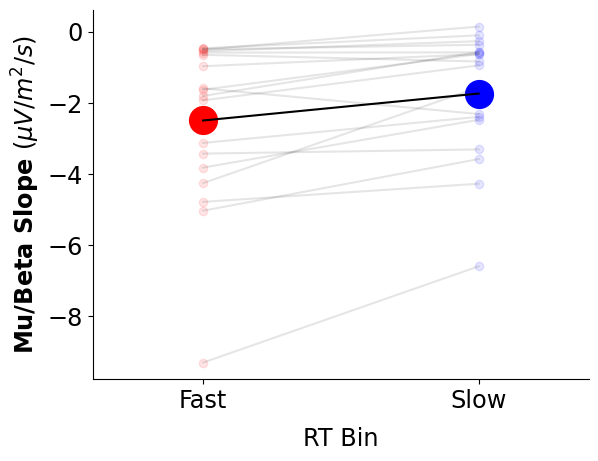

In [35]:
fig, ax = plt.subplots()
ax.set_xticks([0.25, 0.75])
ax.set_xticklabels(["Fast", "Slow"])

ax.plot(0.25, ANOVA_df["Fast"].mean(), marker = "o", markersize = "20", color = colors[0])
ax.plot(0.75, ANOVA_df["Slow"].mean(), marker = "o", markersize = "20", color = colors[1])
ax.plot(np.array([0.25, 0.75]), ANOVA_df.mean(axis = 0), color = "k")

for ID in ID_list:
  participant_df = ANOVA_df.loc[ID]
  ax.plot(0.25, participant_df["Fast"], marker = "o", alpha = 0.1, color = colors[0])
  ax.plot(0.75, participant_df["Slow"], marker = "o", alpha = 0.1, color = colors[1])
  ax.plot([0.25, 0.75], np.array(participant_df), alpha = 0.1, color = "k")

sns.despine()
plt.xlim(0.05, 0.95)
plt.xlabel("RT Bin", fontsize = "xx-large", labelpad = 10)
plt.ylabel("Mu/Beta Slope" + " " + "$(\mu V/m^2/s)$", fontsize = "xx-large", weight='bold')
ax = plt.gca()
ax.tick_params(labelsize = "xx-large")

fname = "/content/drive/MyDrive/Time_Reproduction/Plots/ERPs/" + "RL_Beta_Slope_RT_Bins.png"
plt.savefig(fname, dpi = 300, bbox_inches = "tight")

In [36]:
labels = ["Fast", "Slow"]
conds = [1, 2]

dv = "RL_Beta_Amp"

trial_numbers_RL = np.zeros((len(ID_list), len(conds)))

ANOVA_array = np.zeros((len(ID_list), len(labels)))

mean_RT = np.zeros((len(ID_list), len(conds)))

for i in range(0, len(ID_list)):
  participant_df = RL_metadata[RL_metadata["ID"] == ID_list[i]]

  for j in range(0, len(labels)):
    cond = conds[j]
    #condition_df = participant_df.query("RT_Bin2 == @cond")
    condition_df = participant_df[participant_df["RT_Bin2"] == cond]
    ANOVA_array[i, j] = condition_df[dv].mean()
    trial_numbers_RL[i, j] = condition_df.shape[0]
    mean_RT[i, j] = condition_df["Response_Time"].mean()

ANOVA_df = pd.DataFrame(ANOVA_array, columns = labels, index = ID_list)
ANOVA_df

,Fast,Slow
P1,4.304069,4.070535
P3,5.208774,4.893986
P4,5.126401,5.013414
P7,5.151006,5.180920
P10,4.658819,4.696819
P12,7.817846,7.615052
P15,10.261956,10.176923
P17,4.117796,4.025095
P19,5.301480,5.043574
P21,5.429156,5.166061


In [37]:
if stan:
  fname = "/content/drive/MyDrive/Time_Reproduction/JASP_Files_TR/" + "RL_Beta_Amp_jasp_Med_ANOVA.csv"
  ANOVA_df.to_csv(fname)

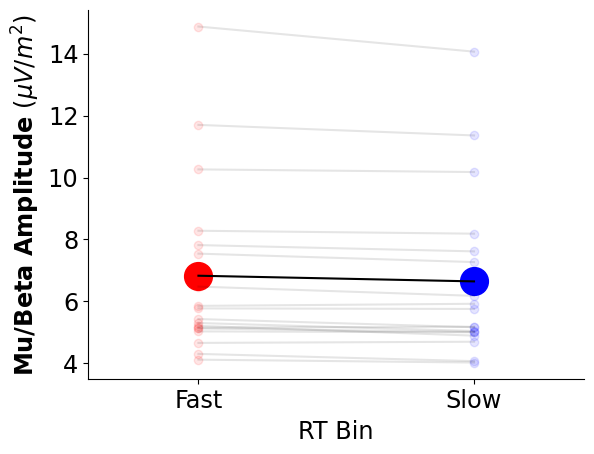

In [38]:
fig, ax = plt.subplots()
ax.set_xticks([0.25, 0.75])
ax.set_xticklabels(["Fast", "Slow"])

ax.plot(0.25, ANOVA_df["Fast"].mean(), marker = "o", markersize = "20", color = colors[0])
ax.plot(0.75, ANOVA_df["Slow"].mean(), marker = "o", markersize = "20", color = colors[1])
ax.plot(np.array([0.25, 0.75]), ANOVA_df.mean(axis = 0), color = "k")

for ID in ID_list:
  participant_df = ANOVA_df.loc[ID]
  ax.plot(0.25, participant_df["Fast"], marker = "o", alpha = 0.1, color = colors[0])
  ax.plot(0.75, participant_df["Slow"], marker = "o", alpha = 0.1, color = colors[1])
  ax.plot([0.25, 0.75], np.array(participant_df), alpha = 0.1, color = "k")

sns.despine()
plt.xlim(0.05, 0.95)
plt.xlabel("RT Bin", fontsize = "xx-large", labelpad = 5)
plt.ylabel("Mu/Beta Amplitude" + " " + "$(\mu V/m^2)$", fontsize = "xx-large", weight='bold')
ax = plt.gca()
ax.tick_params(labelsize = "xx-large")

fname = "/content/drive/MyDrive/Time_Reproduction/Plots/ERPs/" + "RL_Beta_Amp_RT_Bins.png"
plt.savefig(fname, dpi = 300, bbox_inches = "tight")

In [39]:
labels = ["Fast", "Slow"]
conds = [1, 2]

dv = "Repo_Onset_Beta_Amp"

trial_numbers_RL = np.zeros((len(ID_list), len(conds)))

ANOVA_array = np.zeros((len(ID_list), len(labels)))

mean_RT = np.zeros((len(ID_list), len(conds)))

for i in range(0, len(ID_list)):
  participant_df = repo_metadata[repo_metadata["ID"] == ID_list[i]]

  for j in range(0, len(labels)):
    cond = conds[j]
    #condition_df = participant_df.query("RT_Bin2 == @cond")
    condition_df = participant_df[participant_df["RT_Bin2"] == cond]
    ANOVA_array[i, j] = condition_df[dv].mean()
    mean_RT[i, j] = condition_df["Response_Time"].mean()

ANOVA_df = pd.DataFrame(ANOVA_array, columns = labels, index = ID_list)
ANOVA_df

,Fast,Slow
P1,5.984364,5.960644
P3,6.385742,6.542048
P4,6.334921,6.631803
P7,5.710057,5.625819
P10,4.823660,4.907286
P12,8.738959,8.953609
P15,10.495042,10.807505
P17,4.411518,4.416670
P19,5.630873,5.714595
P21,6.711894,6.794799


In [40]:
if stan:
  fname = "/content/drive/MyDrive/Time_Reproduction/JASP_Files_TR/" + "Repo_Onset_Beta_Amp_jasp_Med_ANOVA.csv"
  ANOVA_df.to_csv(fname)

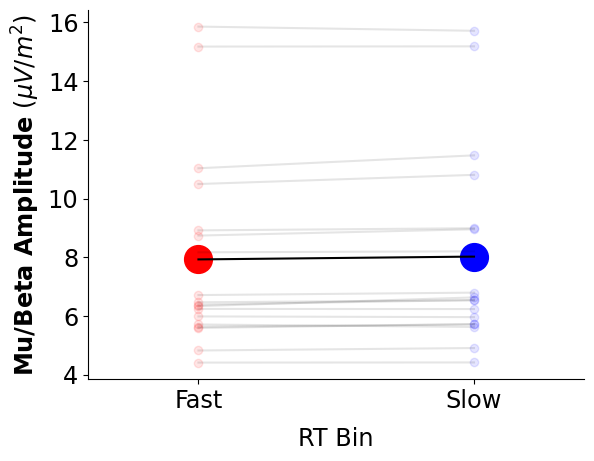

In [41]:
fig, ax = plt.subplots()
ax.set_xticks([0.25, 0.75])
ax.set_xticklabels(["Fast", "Slow"])

ax.plot(0.25, ANOVA_df["Fast"].mean(), marker = "o", markersize = "20", color = colors[0])
ax.plot(0.75, ANOVA_df["Slow"].mean(), marker = "o", markersize = "20", color = colors[1])
ax.plot(np.array([0.25, 0.75]), ANOVA_df.mean(axis = 0), color = "k")

for ID in ID_list:
  participant_df = ANOVA_df.loc[ID]
  ax.plot(0.25, participant_df["Fast"], marker = "o", alpha = 0.1, color = colors[0])
  ax.plot(0.75, participant_df["Slow"], marker = "o", alpha = 0.1, color = colors[1])
  ax.plot([0.25, 0.75], np.array(participant_df), alpha = 0.1, color = "k")

sns.despine()
plt.xlim(0.05, 0.95)
plt.xlabel("RT Bin", fontsize = "xx-large", labelpad = 5)
plt.xlabel("RT Bin", fontsize = "xx-large", labelpad = 10)
plt.ylabel("Mu/Beta Amplitude" + " " + "$(\mu V/m^2)$", fontsize = "xx-large", weight='bold')
ax = plt.gca()
ax.tick_params(labelsize = "xx-large")

fname = "/content/drive/MyDrive/Time_Reproduction/Plots/ERPs/" + "Cue_Onset_Beta_RT_Bins.png"
plt.savefig(fname, dpi = 300, bbox_inches = "tight")

In [42]:
labels = ["Fast", "Slow"]
conds = [1, 2]

dv = "RESP_Beta"

trial_numbers_RL = np.zeros((len(ID_list), len(conds)))

ANOVA_array = np.zeros((len(ID_list), len(labels)))

mean_RT = np.zeros((len(ID_list), len(conds)))

for i in range(0, len(ID_list)):
  participant_df = RL_metadata[RL_metadata["ID"] == ID_list[i]]

  for j in range(0, len(labels)):
    cond = conds[j]
    #condition_df = participant_df.query("RT_Bin2 == @cond")
    condition_df = participant_df[participant_df["RT_Bin2"] == cond]
    ANOVA_array[i, j] = condition_df[dv].mean()
    trial_numbers_RL[i, j] = condition_df.shape[0]
    mean_RT[i, j] = condition_df["Response_Time"].mean()

ANOVA_df = pd.DataFrame(ANOVA_array, columns = labels, index = ID_list)
ANOVA_df

,Fast,Slow
P1,4.083097,4.093387
P3,4.544898,4.401194
P4,4.842610,4.862512
P7,4.570623,4.747635
P10,4.621289,4.636439
P12,7.047844,7.021784
P15,10.260726,10.256362
P17,3.875194,3.820702
P19,5.054819,4.933466
P21,4.619546,4.689095


In [43]:
if stan:
  fname = "/content/drive/MyDrive/Time_Reproduction/JASP_Files_TR/" + "RESP_Beta_jasp_Med_ANOVA.csv"
  ANOVA_df.to_csv(fname)

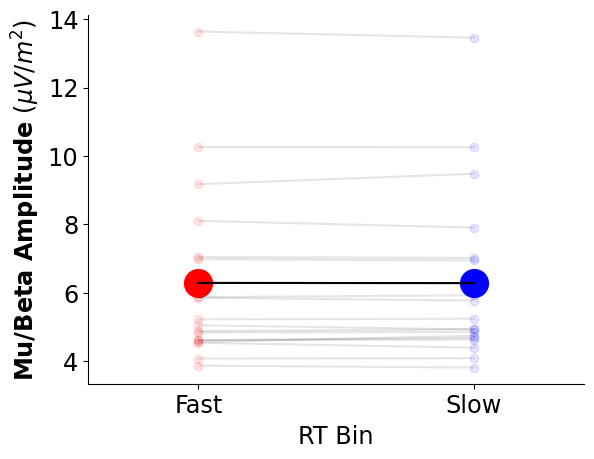

In [44]:
fig, ax = plt.subplots()
ax.set_xticks([0.25, 0.75])
ax.set_xticklabels(["Fast", "Slow"])

ax.plot(0.25, ANOVA_df["Fast"].mean(), marker = "o", markersize = "20", color = colors[0])
ax.plot(0.75, ANOVA_df["Slow"].mean(), marker = "o", markersize = "20", color = colors[1])
ax.plot(np.array([0.25, 0.75]), ANOVA_df.mean(axis = 0), color = "k")

for ID in ID_list:
  participant_df = ANOVA_df.loc[ID]
  ax.plot(0.25, participant_df["Fast"], marker = "o", alpha = 0.1, color = colors[0])
  ax.plot(0.75, participant_df["Slow"], marker = "o", alpha = 0.1, color = colors[1])
  ax.plot([0.25, 0.75], np.array(participant_df), alpha = 0.1, color = "k")

sns.despine()
plt.xlim(0.05, 0.95)
plt.xlabel("RT Bin", fontsize = "xx-large", labelpad = 5)
plt.ylabel("Mu/Beta Amplitude" + " " + "$(\mu V/m^2)$", fontsize = "xx-large", weight='bold')
ax = plt.gca()
ax.tick_params(labelsize = "xx-large")

fname = "/content/drive/MyDrive/Time_Reproduction/Plots/ERPs/" + "RESP_Beta_RT_Bins.png"
plt.savefig(fname, dpi = 300, bbox_inches = "tight")

In [45]:
labels = ["Fast", "Slow"]
conds = [1, 2]

dv = "Encode_Offset_Beta_Amp"

ANOVA_array = np.zeros((len(ID_list), len(labels)))

mean_RT = np.zeros((len(ID_list), len(conds)))

for i in range(0, len(ID_list)):
  participant_df = encode_metadata[encode_metadata["ID"] == ID_list[i]]

  for j in range(0, len(labels)):
    cond = conds[j]
    #condition_df = participant_df.query("RT_Bin2 == @cond")
    condition_df = participant_df[participant_df["RT_Bin2"] == cond]
    ANOVA_array[i, j] = condition_df[dv].mean()
    mean_RT[i, j] = condition_df["Response_Time"].mean()

ANOVA_df = pd.DataFrame(ANOVA_array, columns = labels, index = ID_list)
ANOVA_df

,Fast,Slow
P1,6.267001,6.173994
P3,6.480022,6.342883
P4,7.387645,7.231827
P7,5.867626,5.670850
P10,4.876621,4.993896
P12,8.812660,8.709202
P15,10.893992,10.855083
P17,4.526005,4.456096
P19,6.268069,6.386276
P21,7.100792,7.057082


In [46]:
if stan:
  fname = "/content/drive/MyDrive/Time_Reproduction/JASP_Files_TR/" + "Encode_Offset_Beta_Amp_jasp_Med_ANOVA.csv"
  ANOVA_df.to_csv(fname)

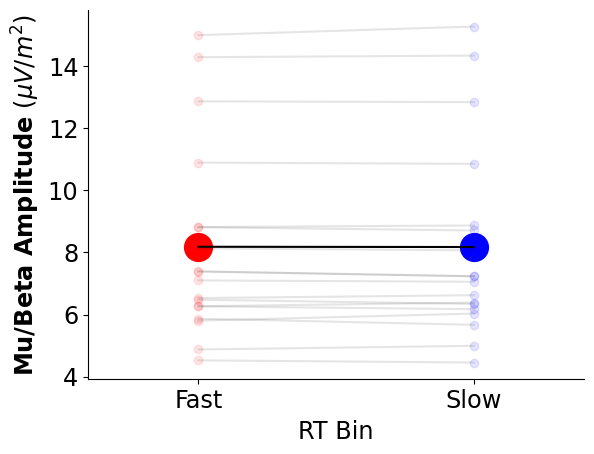

In [47]:
fig, ax = plt.subplots()
ax.set_xticks([0.25, 0.75])
ax.set_xticklabels(["Fast", "Slow"])

ax.plot(0.25, ANOVA_df["Fast"].mean(), marker = "o", markersize = "20", color = colors[0])
ax.plot(0.75, ANOVA_df["Slow"].mean(), marker = "o", markersize = "20", color = colors[1])
ax.plot(np.array([0.25, 0.75]), ANOVA_df.mean(axis = 0), color = "k")

for ID in ID_list:
  participant_df = ANOVA_df.loc[ID]
  ax.plot(0.25, participant_df["Fast"], marker = "o", alpha = 0.1, color = colors[0])
  ax.plot(0.75, participant_df["Slow"], marker = "o", alpha = 0.1, color = colors[1])
  ax.plot([0.25, 0.75], np.array(participant_df), alpha = 0.1, color = "k")

sns.despine()
plt.xlim(0.05, 0.95)
plt.xlabel("RT Bin", fontsize = "xx-large", labelpad = 5)
plt.ylabel("Mu/Beta Amplitude" + " " + "$(\mu V/m^2)$", fontsize = "xx-large", weight='bold')
ax = plt.gca()
ax.tick_params(labelsize = "xx-large")

fname = "/content/drive/MyDrive/Time_Reproduction/Plots/ERPs/" + "Encode_Offset_Beta_Amp_RT_Bins.png"
plt.savefig(fname, dpi = 300, bbox_inches = "tight")

In [48]:
labels = ["Fast", "Slow"]
conds = [1, 2]

dv = "Encode_Offset_Beta_Slope"

ANOVA_array = np.zeros((len(ID_list), len(labels)))

mean_RT = np.zeros((len(ID_list), len(conds)))

for i in range(0, len(ID_list)):
  participant_df = encode_metadata[encode_metadata["ID"] == ID_list[i]]

  for j in range(0, len(labels)):
    cond = conds[j]
    #condition_df = participant_df.query("RT_Bin2 == @cond")
    condition_df = participant_df[participant_df["RT_Bin2"] == cond]
    ANOVA_array[i, j] = condition_df[dv].mean()
    mean_RT[i, j] = condition_df["Response_Time"].mean()

ANOVA_df = pd.DataFrame(ANOVA_array, columns = labels, index = ID_list)
ANOVA_df

,Fast,Slow
P1,2.008309,1.289950
P3,-0.222137,0.499501
P4,-1.161175,-1.509564
P7,0.219222,1.468852
P10,-0.029016,-0.030379
P12,-0.706107,-0.688963
P15,1.048653,-1.217542
P17,-1.196253,0.006372
P19,-2.400308,-2.128813
P21,-0.036303,-0.710490


In [49]:
if stan:
  fname = "/content/drive/MyDrive/Time_Reproduction/JASP_Files_TR/" + "Encode_Offset_Beta_Slope_jasp_Med_ANOVA.csv"
  ANOVA_df.to_csv(fname)

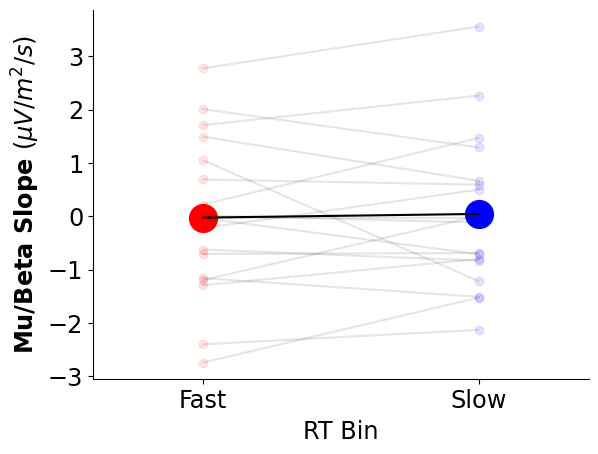

In [50]:
fig, ax = plt.subplots()
ax.set_xticks([0.25, 0.75])
ax.set_xticklabels(["Fast", "Slow"])

ax.plot(0.25, ANOVA_df["Fast"].mean(), marker = "o", markersize = "20", color = colors[0])
ax.plot(0.75, ANOVA_df["Slow"].mean(), marker = "o", markersize = "20", color = colors[1])
ax.plot(np.array([0.25, 0.75]), ANOVA_df.mean(axis = 0), color = "k")

for ID in ID_list:
  participant_df = ANOVA_df.loc[ID]
  ax.plot(0.25, participant_df["Fast"], marker = "o", alpha = 0.1, color = colors[0])
  ax.plot(0.75, participant_df["Slow"], marker = "o", alpha = 0.1, color = colors[1])
  ax.plot([0.25, 0.75], np.array(participant_df), alpha = 0.1, color = "k")

sns.despine()
plt.xlim(0.05, 0.95)
plt.xlabel("RT Bin", fontsize = "xx-large", labelpad = 5)
plt.ylabel("Mu/Beta Slope" + " " + "$(\mu V/m^2/s)$", fontsize = "xx-large", weight='bold')
ax = plt.gca()
ax.tick_params(labelsize = "xx-large")

fname = "/content/drive/MyDrive/Time_Reproduction/Plots/ERPs/" + "Encode_Offset_Beta_Slope_RT_Bins.png"
plt.savefig(fname, dpi = 300, bbox_inches = "tight")